In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time
from generator_functions import random_uni_points_in_ball
from visualizations import plot_avkersize_conv, plot_times_comput, plot_wckersize_conv
from accuracy_bounds.inverseproblems.feasible_sets import compute_feasible_set_linear_forwardmodel
from accuracy_bounds.inverseproblems.kersize_compute import worstcase_kernelsize, worstcase_kernelsize_sym, average_kernelsize, average_kernelsize_sym
from accuracy_bounds.inverseproblems.utils import projection_nullspace, apply_forwardmodel, projection_nullspace_operator
# these need to be tested against analytical values:
from accuracy_bounds.inverseproblems.kersize_compute_dataloader import kersize_samplingYX,feasibleApp_samplingYX_perbatch_cuda,feasibleApp_samplingYX_linear_cuda ,target_distances_samplingYX_precomputedFA_cuda_V2, avgLB_samplingYX
from accuracy_bounds.inverseproblems.utils import torch_sparse_to_scipy_csr, torch_csr_to_scipy


# Tests

## Toy example 1 : 3D ball

In [2]:

# Toy example 1
num_points = 2000
radius = 2
center = (0,0,0)
dim = 3
epsilon=1e-1
seed = 43

# Toy forward operator
A = np.diag([1, 1, 0])  # Transformation matrix


target_data = random_uni_points_in_ball(num_points=num_points, radius=radius+epsilon, center=center, dim=3)   
input_data = apply_forwardmodel(A, target_data)



#analytical wc kersize for ball around 0 with radius r+epsilon
wc_kernel_size_analytical = 2*radius+2*epsilon
#analytical av kersize for ball around 0 with radius r+epsilon sampled with uniform distribution
av_kernel_size_analytical = np.multiply((radius+epsilon),np.power(1/3,1/2))

# Distance measure
p_1=2
p_2=2
# Kernel Size order
p=2



# Set the range of k values
max_k = 300
input_target_pairs = 2000

# Step 1: Compute feasible sets from the linear forward model and data:
feasible_sets_list = []
for y in input_data[:input_target_pairs]:
    feas_set_y = compute_feasible_set_linear_forwardmodel(A, y, target_data[:input_target_pairs], p_2, epsilon)
    feasible_sets_list.append(feas_set_y)

### Worst case Kersize with symetric assumption, without parallelization

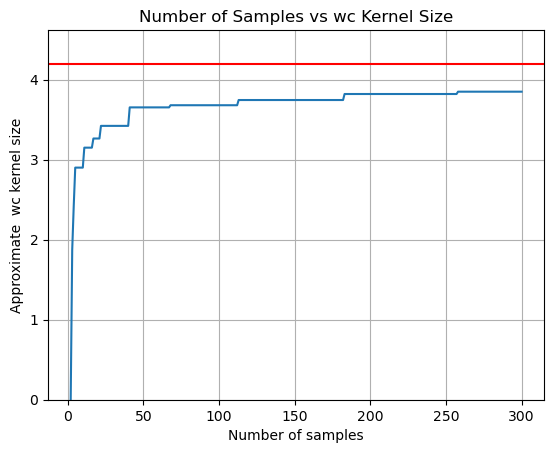

Total Max Kernel Size: 3.8505103334765045
Analytical Kernel Size: 4.2
Relative Error: -0.08321182536273707


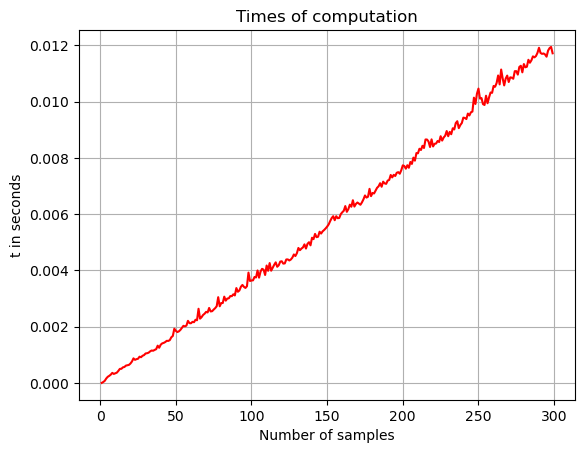

The last kernel size computation took 0.011720 seconds


In [ ]:
# Step 2: Compute worst-case kernel sizes:
worstcase_kersize = worstcase_kernelsize(feasible_sets_list, p_1, p)

worstcase_kersize_list = []
times_comput = []
for k in range(0,max_k-1):
    t0 = time.time()
    worstcase_kersize =  worstcase_kernelsize(feasible_sets_list[:k], p_1, p)
    worstcase_kersize_list.append(worstcase_kersize)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_wckersize_conv(worstcase_kersize, worstcase_kersize_list, wc_kernel_size_analytical, np.arange(2, max_k+1))

plot_times_comput(list(range(1,max_k,1)), times_comput)


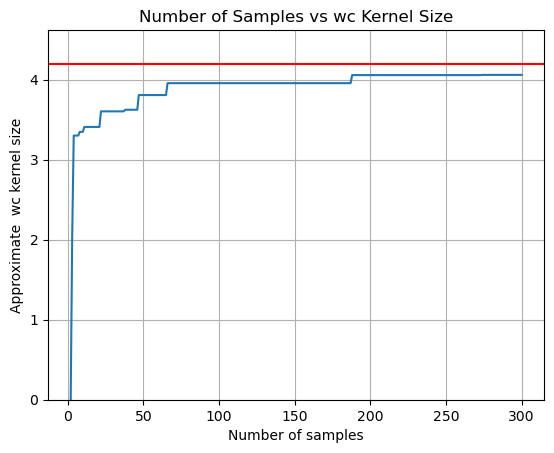

Total Max Kernel Size: 4.060272764258663
Analytical Kernel Size: 4.2
Relative Error: -0.03326838946222316


In [ ]:
# Step 2: Compute worst-case kernel sizes with symmetry assumption:
worstcase_kersize_sym = worstcase_kernelsize_sym(A, input_data[:input_target_pairs], target_data, p_1, p_2, p, 2*epsilon)

worstcase_kersize_sym_list = []
times_comput = []
for k in range(0,max_k-1):
    t0 = time.time()
    worstcase_kersize_sym = worstcase_kernelsize_sym(A, input_data[:k], target_data, p_1, p_2, p, epsilon)
    worstcase_kersize_sym_list.append(worstcase_kersize_sym)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_wckersize_conv(worstcase_kersize_sym, worstcase_kersize_sym_list, wc_kernel_size_analytical, np.arange(2, max_k+1))
plot_times_comput(list(range(1,max_k,1)), times_comput)

### Worst-case kernel size for linear forward model with additive noise, parallelized

In [3]:
batch_size = 100

input_loader1 = DataLoader(input_data, batch_size=batch_size, num_workers=batch_size, drop_last=False)
input_loader2 = DataLoader(input_data, batch_size=batch_size, num_workers=batch_size, drop_last=False)
target_loader1 = DataLoader(target_data, batch_size=batch_size, num_workers=batch_size, drop_last=False)
target_loader2 = DataLoader(target_data, batch_size=batch_size, num_workers=batch_size, drop_last=False) 

/localhome/iaga_dv/Dokumente/AccuracyBounds/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 100 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


First test the 2 ways of computing feasible appartenance

In [4]:
t0 = time.time()
feas_app_1 = feasibleApp_samplingYX_perbatch_cuda(0, input_loader1, input_loader2, p_Y=2, epsilon=epsilon)
t1 = time.time()
feas_app_2 = feasibleApp_samplingYX_linear_cuda(0, input_loader1, input_loader2, p_Y=2, epsilon= epsilon, batchsize = 1000)
t2 = time.time()

print(f'Per batch : tool {t1-t0:.4f} seconds')
print(f'With candidate selection : {t2-t1:.4f} seconds')


/localhome/iaga_dv/Dokumente/AccuracyBounds/src/accuracy_bounds/inverseproblems/kersize_compute_dataloader.py:374: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  forwarded_target = torch.tensor(forwarded_target, dtype = torch.float32, device = device)
/localhome/iaga_dv/Dokumente/AccuracyBounds/src/accuracy_bounds/inverseproblems/kersize_compute_dataloader.py:375: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(input_data, dtype = torch.float32, device = device)
/localhome/iaga_dv/Dokumente/AccuracyBounds/src/accuracy_bounds/inverseproblems/kersize_compute_dataloader.py:379: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach(

Filtering candidates with distance LBtch: [20 / 20]                    
Loading input batches
Loading forwarded target batches


/localhome/iaga_dv/Dokumente/AccuracyBounds/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:201: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Number of candidates : 452238 
 ratio = 0.1130595
Computing exact distances for candidates
Per batch : tool 23.6842 seconds
With candidate selection : 3.8595 seconds


In [6]:
delta = feas_app_1 - feas_app_2.to(dtype=feas_app_1.dtype)
print(f'Difference between the computations {delta.sum()}')

Difference between the computations 0.0


Then, test the kersize with 1 of the 2 feas app and both target_dists_preomputed FA

  0%|          | 0/18 [00:00<?, ?it/s]/localhome/iaga_dv/Dokumente/AccuracyBounds/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 100 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


/localhome/iaga_dv/Dokumente/AccuracyBounds/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:201: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


  6%|▌         | 1/18 [00:02<00:48,  2.84s/it]

 11%|█         | 2/18 [00:05<00:46,  2.91s/it]

 17%|█▋        | 3/18 [00:08<00:42,  2.86s/it]

 22%|██▏       | 4/18 [00:11<00:40,  2.87s/it]

 28%|██▊       | 5/18 [00:14<00:37,  2.90s/it]

 33%|███▎      | 6/18 [00:17<00:35,  3.00s/it]

 39%|███▉      | 7/18 [00:21<00:35,  3.19s/it]

 44%|████▍     | 8/18 [00:25<00:33,  3.38s/it]

 50%|█████     | 9/18 [00:29<00:33,  3.72s/it]

 56%|█████▌    | 10/18 [00:34<00:32,  4.10s/it]

 61%|██████    | 11/18 [00:38<00:28,  4.09s/it]

 67%|██████▋   | 12/18 [00:43<00:25,  4.24s/it]

 72%|███████▏  | 13/18 [00:48<00:23,  4.62s/it]

 78%|███████▊  | 14/18 [00:54<00:19,  4.92s/it]

 83%|████████▎ | 15/18 [00:59<00:14,  5.00s/it]

 89%|████████▉ | 16/18 [01:04<00:10,  5.10s/it]

 94%|█████████▍| 17/18 [01:10<00:05,  5.39s/it]

100%|██████████| 18/18 [01:17<00:00,  4.30s/it]

<class 'list'>
[100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950]


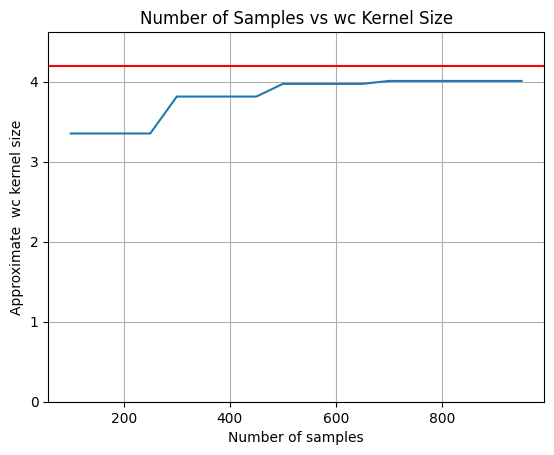

Total Max Kernel Size: 4.009903994900083
Analytical Kernel Size: 4.2
Relative Error: -0.04526095359521843


In [6]:
from tqdm import tqdm
import torch

max_k = 1000
batch_size = 100
wc_kersizes = []
times_comput_FA = []
times_comput_WC = []

for k in tqdm(range(100,max_k,50)):
    input_data_k = input_data[0:k,:]
    target_data_k = target_data[0:k,:]
    input_loader1 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    input_loader2 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader1 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader2 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)   

    t0 = time.time()
    feasible_appartenance = feasibleApp_samplingYX_linear_cuda(0, input_loader1, input_loader2, p_Y=p_2, epsilon= 2*epsilon, batchsize = k)
    feasible_appartenance = feasible_appartenance.to(dtype=torch.float32).to_sparse_coo()

    t1 = time.time()
    distsXX, feasible_appartenance = target_distances_samplingYX_precomputedFA_cuda_V2(0, target_loader1, feasible_appartenance, p_X=p_1, batchsize=k)
    
    
    feasible_appartenance = torch_csr_to_scipy(feasible_appartenance.cpu().to_sparse_csr())
    distsXX = torch_sparse_to_scipy_csr(distsXX)

    wc_kersize_k = kersize_samplingYX(distsXX, feasible_appartenance)
    t2 = time.time()
    times_comput_FA.append(t1-t0)
    times_comput_WC.append(t2-t1)
    wc_kersizes.append(wc_kersize_k)

wc_kersizef = wc_kersizes[-1]

plot_wckersize_conv(wc_kersizef, wc_kersizes, wc_kernel_size_analytical, list(range(100,max_k,50)))

#print('Feasible appartenance computation times :')
#plot_times_comput(list(range(50,max_k,10)), times_comput_FA)
#print('WC Kersize computation times : ')
#plot_times_comput(list(range(50,max_k,10)), times_comput_WC)




### Average kernel size

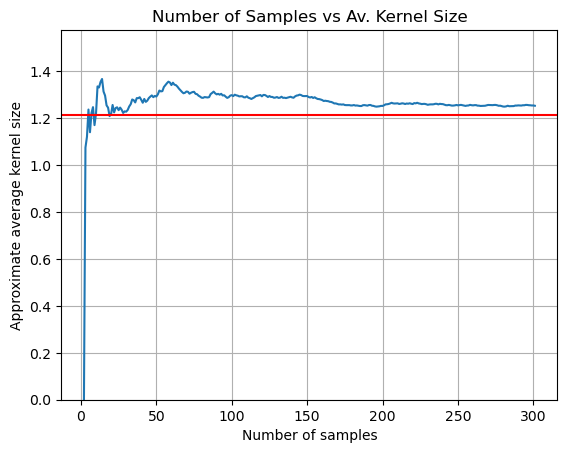

Total Max Kernel Size: 1.2535806379503631
Analytical Kernel Size: 1.2124355652982142
Relative Error: 0.03393588395934986


In [ ]:
# Step 2: Compute average kernel sizes:
average_kersize = average_kernelsize(feasible_sets_list, p_1, p)

average_kersize_list = []
times_comput = []
for k in range(0,max_k):
    t0 = time.time()
    average_kersize =  average_kernelsize(feasible_sets_list[:k], p_1, p)
    average_kersize_list.append(average_kersize)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_avkersize_conv(average_kersize,average_kersize_list, av_kernel_size_analytical, max_k+1)
plot_times_comput(list(range(1,max_k,1)), times_comput)

In [ ]:
# Step 2: Compute average symmetric kernel sizes:
average_kersize_sym = average_kernelsize_sym(A, input_data, target_data, p_1, p_2, p, epsilon)

average_kersize_sym_list = []
times_comput = []
for k in range(0,max_k):
    t0 = time.time()
    average_kersize_sym =  average_kernelsize_sym(A, input_data[:k], target_data, p_1, p_2, p, epsilon)
    average_kersize_sym_list.append(average_kersize_sym)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_avkersize_conv(average_kersize_sym,average_kersize_sym_list, av_kernel_size_analytical, max_k)
plot_times_comput(list(range(1,max_k,1)), times_comput)